In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=160, dpi_save=500)

scanpy==1.4 anndata==0.6.18 numpy==1.16.1 scipy==1.2.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
fname_list = ['../../TM_datasets/Lung-10X_P7_8', '../../TM_datasets/Lung-10X_P7_9', '../../TM_datasets/Lung-10X_P8_12', '../../TM_datasets/Lung-10X_P8_13']
anno_fname = "../Anno_TM.csv"

In [4]:
batch_list = [fname.split('/')[-1] for fname in fname_list]
batch_list

['Lung-10X_P7_8', 'Lung-10X_P7_9', 'Lung-10X_P8_12', 'Lung-10X_P8_13']

In [5]:
adata_list = [sc.read_10x_mtx(fname, var_names='gene_symbols', cache=True) for fname in fname_list]

... reading from cache file ./cache/TM_datasets-Lung-10X_P7_8-matrix.h5ad
... reading from cache file ./cache/TM_datasets-Lung-10X_P7_9-matrix.h5ad
... reading from cache file ./cache/TM_datasets-Lung-10X_P8_12-matrix.h5ad
... reading from cache file ./cache/TM_datasets-Lung-10X_P8_13-matrix.h5ad


In [6]:
adata_list[3]

AnnData object with n_obs × n_vars = 737280 × 23433 
    var: 'gene_ids'

In [7]:
adata = adata_list[0].concatenate(*adata_list[1:], join='inner', batch_key='batch', batch_categories=batch_list)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 1476710 × 23433 
    obs: 'batch'
    var: 'gene_ids-Lung-10X_P7_8', 'gene_ids-Lung-10X_P7_9', 'gene_ids-Lung-10X_P8_12', 'gene_ids-Lung-10X_P8_13'

In [12]:
obs = adata.obs
obs['CellID'] = adata.obs.index.map(lambda x: x.split('-')[-1]+'_'+x.split('-')[0])
obs.iloc[:5,:]

batch                     CellID
AAACGGGAGGATATAC-1-Lung-10X_P7_8  Lung-10X_P7_8  10X_P7_8_AAACGGGAGGATATAC
AAACGGGTCTCGTATT-1-Lung-10X_P7_8  Lung-10X_P7_8  10X_P7_8_AAACGGGTCTCGTATT
AAAGATGCAGATCTGT-1-Lung-10X_P7_8  Lung-10X_P7_8  10X_P7_8_AAAGATGCAGATCTGT
AAATGCCAGATAGTCA-1-Lung-10X_P7_8  Lung-10X_P7_8  10X_P7_8_AAATGCCAGATAGTCA
AAATGCCCAAACTGCT-1-Lung-10X_P7_8  Lung-10X_P7_8  10X_P7_8_AAATGCCCAAACTGCT

In [10]:
anno_df = pd.read_csv(anno_fname, header=0, index_col=0, sep=',')
anno_df.iloc[:5,:]

cell_ontology_class   channel tissue                     CellID    CellType
0         myeloid cell  10X_P7_8   Lung  10X_P7_8_AAACGGGAGGATATAC     Myeloid
1  alveolar macrophage  10X_P7_8   Lung  10X_P7_8_AAACGGGTCTCGTATT  Macrophage
2               B cell  10X_P7_8   Lung  10X_P7_8_AAAGATGCAGATCTGT      B cell
3  natural killer cell  10X_P7_8   Lung  10X_P7_8_AAATGCCAGATAGTCA     NK cell
4               T cell  10X_P7_8   Lung  10X_P7_8_AAATGCCCAAACTGCT      T cell

In [13]:
# process with annotation
obs_anno = obs.merge(anno_df, how='left', on='CellID', sort=False)
obs_anno.index = obs.index
obs_anno.iloc[:5,:]

batch                     CellID  \
AAACGGGAGGATATAC-1-Lung-10X_P7_8  Lung-10X_P7_8  10X_P7_8_AAACGGGAGGATATAC   
AAACGGGTCTCGTATT-1-Lung-10X_P7_8  Lung-10X_P7_8  10X_P7_8_AAACGGGTCTCGTATT   
AAAGATGCAGATCTGT-1-Lung-10X_P7_8  Lung-10X_P7_8  10X_P7_8_AAAGATGCAGATCTGT   
AAATGCCAGATAGTCA-1-Lung-10X_P7_8  Lung-10X_P7_8  10X_P7_8_AAATGCCAGATAGTCA   
AAATGCCCAAACTGCT-1-Lung-10X_P7_8  Lung-10X_P7_8  10X_P7_8_AAATGCCCAAACTGCT   

                                  cell_ontology_class   channel tissue  \
AAACGGGAGGATATAC-1-Lung-10X_P7_8         myeloid cell  10X_P7_8   Lung   
AAACGGGTCTCGTATT-1-Lung-10X_P7_8  alveolar macrophage  10X_P7_8   Lung   
AAAGATGCAGATCTGT-1-Lung-10X_P7_8               B cell  10X_P7_8   Lung   
AAATGCCAGATAGTCA-1-Lung-10X_P7_8  natural killer cell  10X_P7_8   Lung   
AAATGCCCAAACTGCT-1-Lung-10X_P7_8               T cell  10X_P7_8   Lung   

                                    CellType  
AAACGGGAGGATATAC-1-Lung-10X_P7_8     Myeloid  
AAACGGGTCTCGTATT-1-Lung-10X_P7_8  Macrophage  
AAAGATGCAGATCTGT-1-Lung-10X_P7_8      B cell  
AAATGCCAGATAGTCA-1-Lung-10X_P7_8     NK cell  
AAATGCCCAAACTGCT-1-Lung-10X_P7_8      T cell

In [14]:
obs_anno['CellType'] = obs_anno['CellType'].fillna("Other")
obs_anno['CellType'].isna()

AAACGGGAGGATATAC-1-Lung-10X_P7_8     False
AAACGGGTCTCGTATT-1-Lung-10X_P7_8     False
AAAGATGCAGATCTGT-1-Lung-10X_P7_8     False
AAATGCCAGATAGTCA-1-Lung-10X_P7_8     False
AAATGCCCAAACTGCT-1-Lung-10X_P7_8     False
AAATGCCGTGAACCTT-1-Lung-10X_P7_8     False
AACACGTAGTGTACCT-1-Lung-10X_P7_8     False
AACACGTGTGGCTCCA-1-Lung-10X_P7_8     False
AACCATGAGTTGTCGT-1-Lung-10X_P7_8     False
AACCATGCACGTCAGC-1-Lung-10X_P7_8     False
AACCATGGTAATAGCA-1-Lung-10X_P7_8     False
AACCATGTCTGTTGAG-1-Lung-10X_P7_8     False
AACCGCGGTTACGGAG-1-Lung-10X_P7_8     False
AACCGCGTCCTTGCCA-1-Lung-10X_P7_8     False
AACGTTGGTAGCTCCG-1-Lung-10X_P7_8     False
AACGTTGTCAACACAC-1-Lung-10X_P7_8     False
AACTCAGCATTTCACT-1-Lung-10X_P7_8     False
AACTCCCTCTTATCTG-1-Lung-10X_P7_8     False
AACTCTTGTTCCAACA-1-Lung-10X_P7_8     False
AACTCTTTCTTGTTTG-1-Lung-10X_P7_8     False
AACTGGTGTTCAGTAC-1-Lung-10X_P7_8     False
AACTTTCAGAGCTGCA-1-Lung-10X_P7_8     False
AAGCCGCTCAGTTCGA-1-Lung-10X_P7_8     False
AAGGAGCCACT

In [15]:
adata.obs = obs_anno
adata

AnnData object with n_obs × n_vars = 1476710 × 23433 
    obs: 'batch', 'CellID', 'cell_ontology_class', 'channel', 'tissue', 'CellType'
    var: 'gene_ids-Lung-10X_P7_8', 'gene_ids-Lung-10X_P7_9', 'gene_ids-Lung-10X_P8_12', 'gene_ids-Lung-10X_P8_13'

filtered out 975917 cells that have less than 1 counts


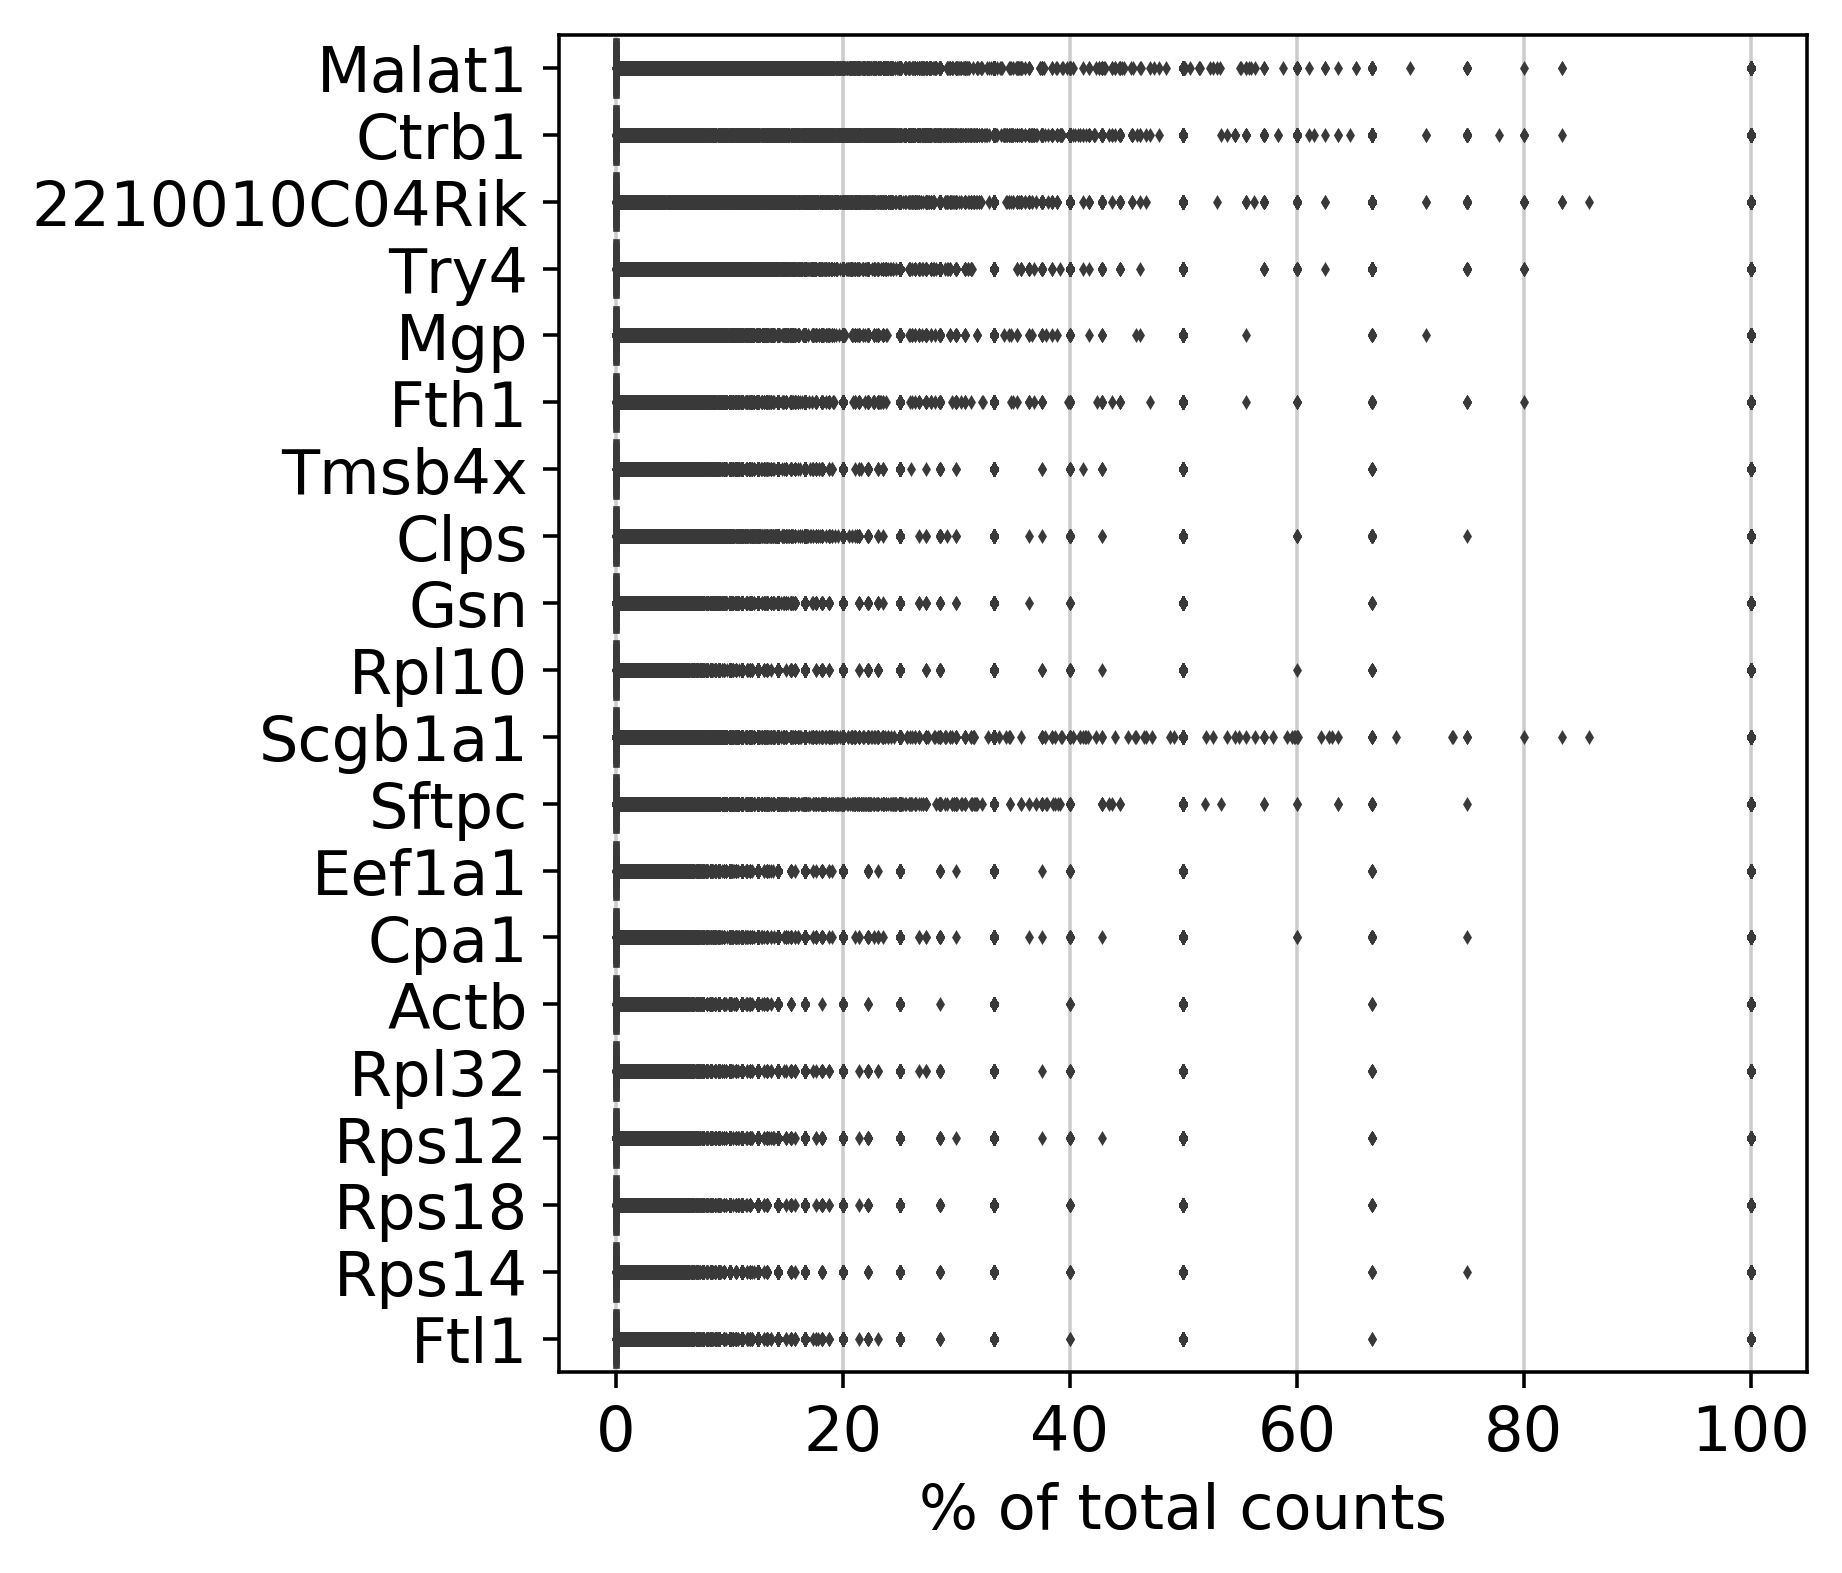

In [16]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [17]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1470519 cells that have less than 200 genes expressed
filtered out 7431 genes that are detected in less than 3 cells


In [18]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'cell_ontology_class' as categorical
... storing 'channel' as categorical
... storing 'tissue' as categorical
... storing 'CellType' as categorical


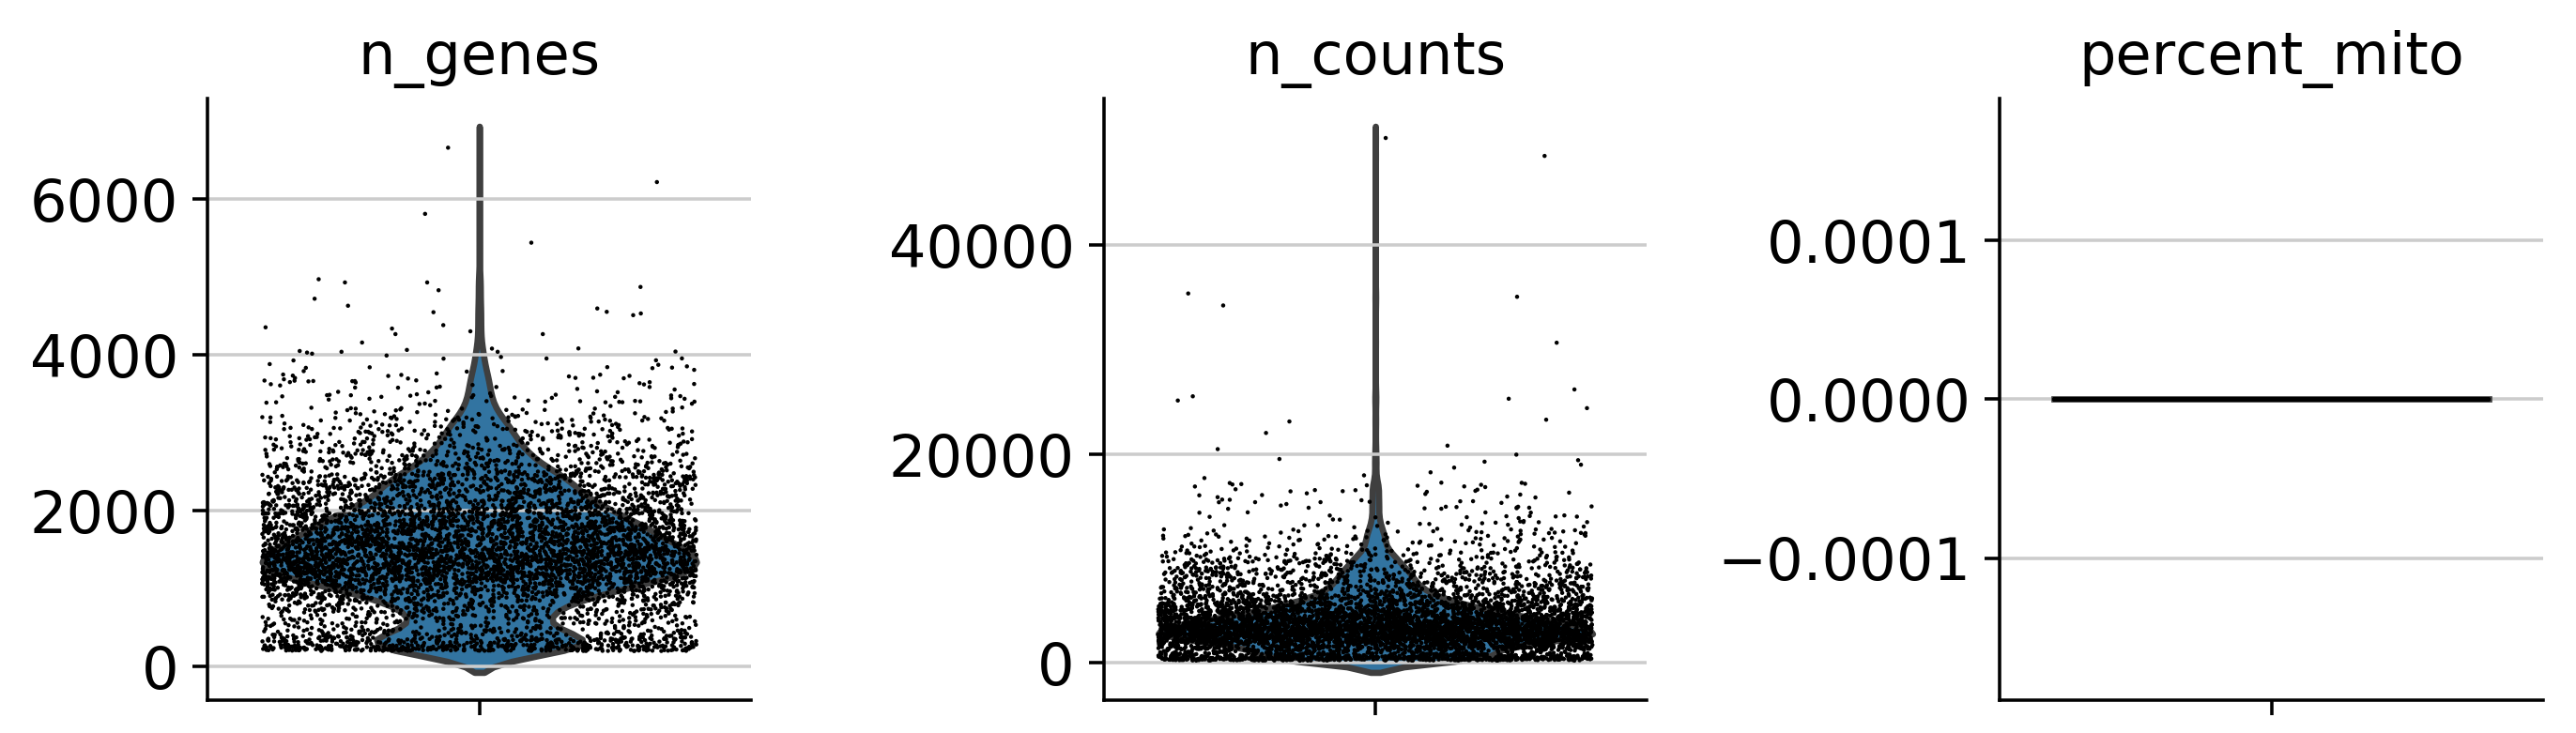

In [19]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

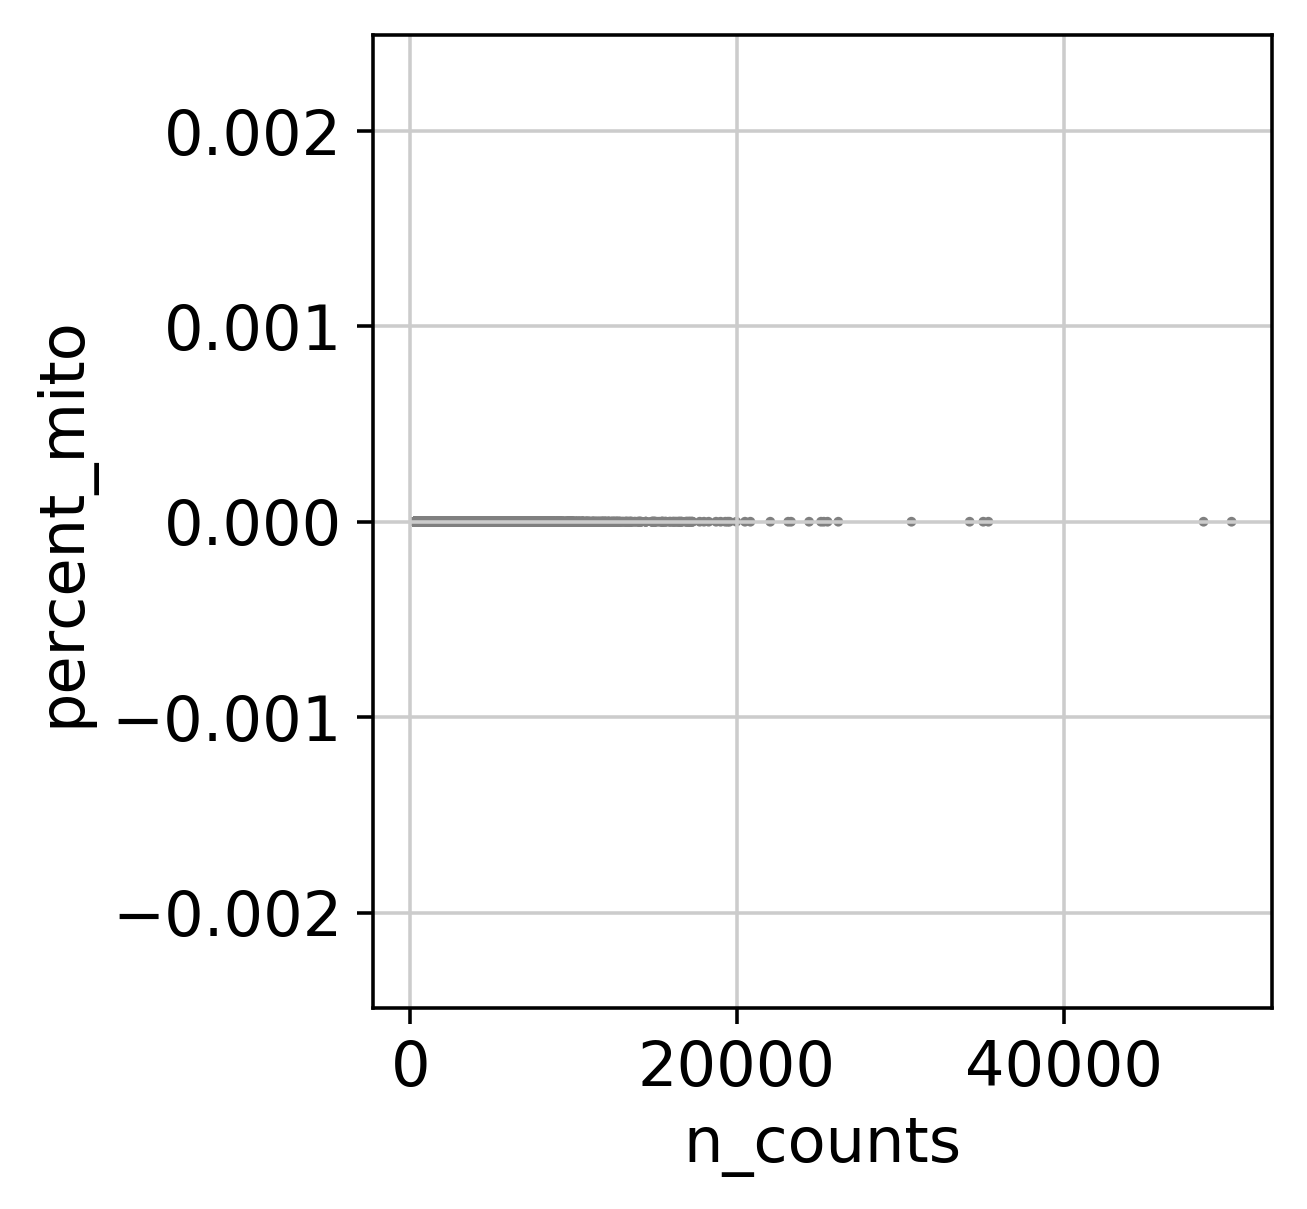

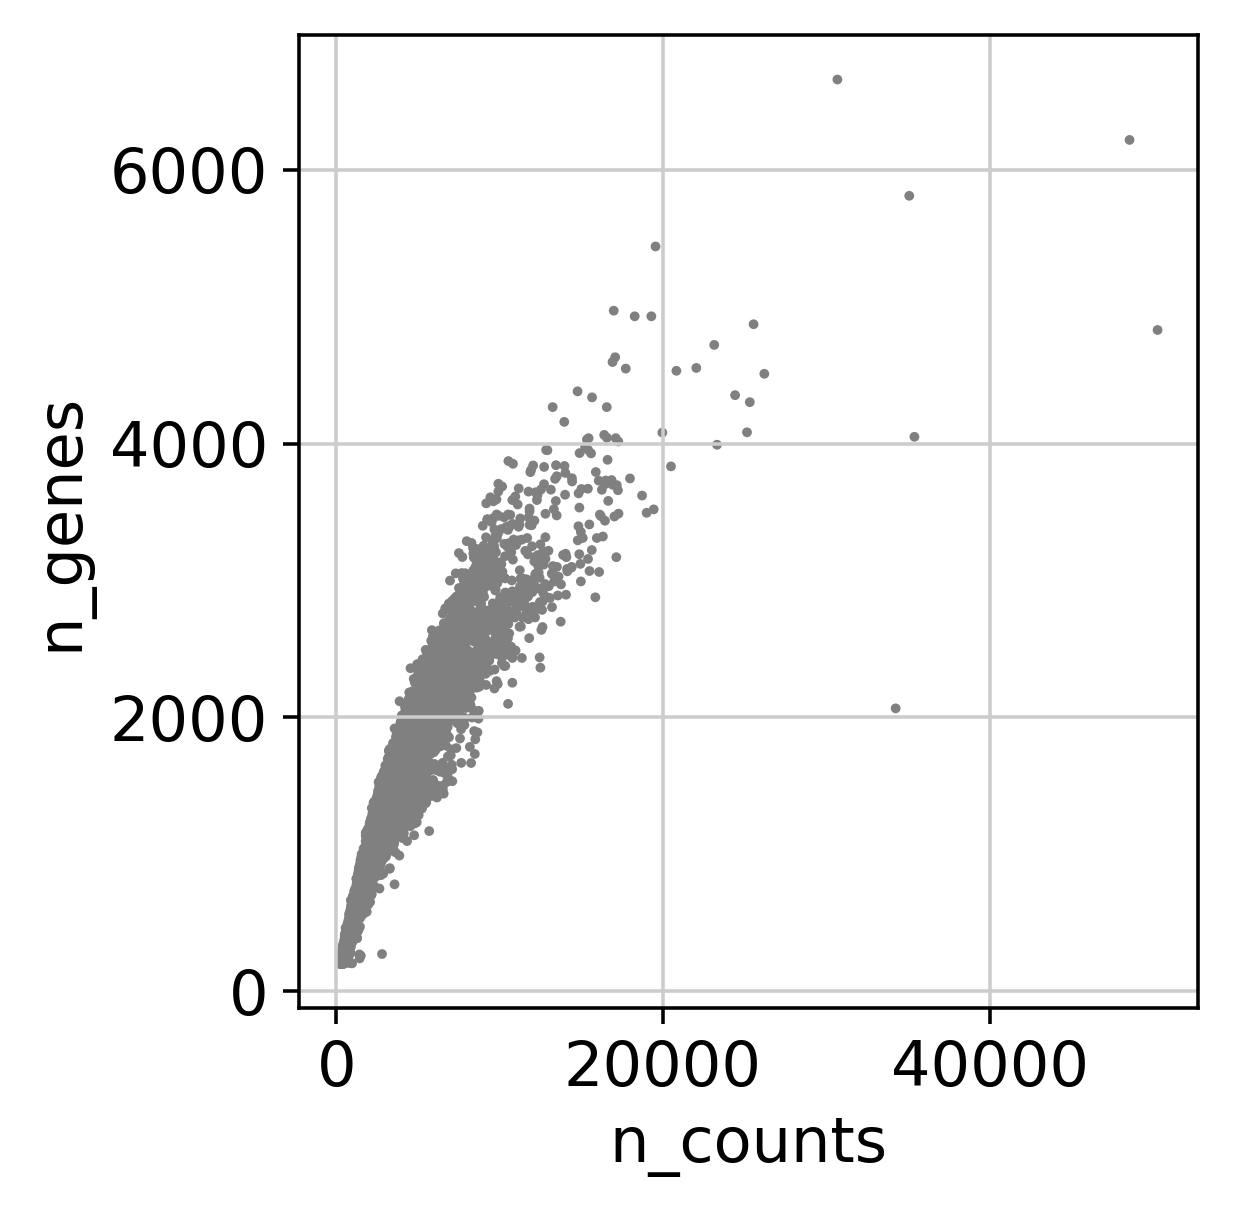

In [20]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [21]:
adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [22]:
adata

View of AnnData object with n_obs × n_vars = 5500 × 16002 
    obs: 'batch', 'CellID', 'cell_ontology_class', 'channel', 'tissue', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids-Lung-10X_P7_8', 'gene_ids-Lung-10X_P7_9', 'gene_ids-Lung-10X_P8_12', 'gene_ids-Lung-10X_P8_13', 'n_cells'

In [23]:
np.unique(adata.obs.batch, return_counts=True)

(array(['Lung-10X_P7_8', 'Lung-10X_P7_9', 'Lung-10X_P8_12',
        'Lung-10X_P8_13'], dtype=object), array([ 462, 1286,  963, 2789]))

In [20]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [21]:
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


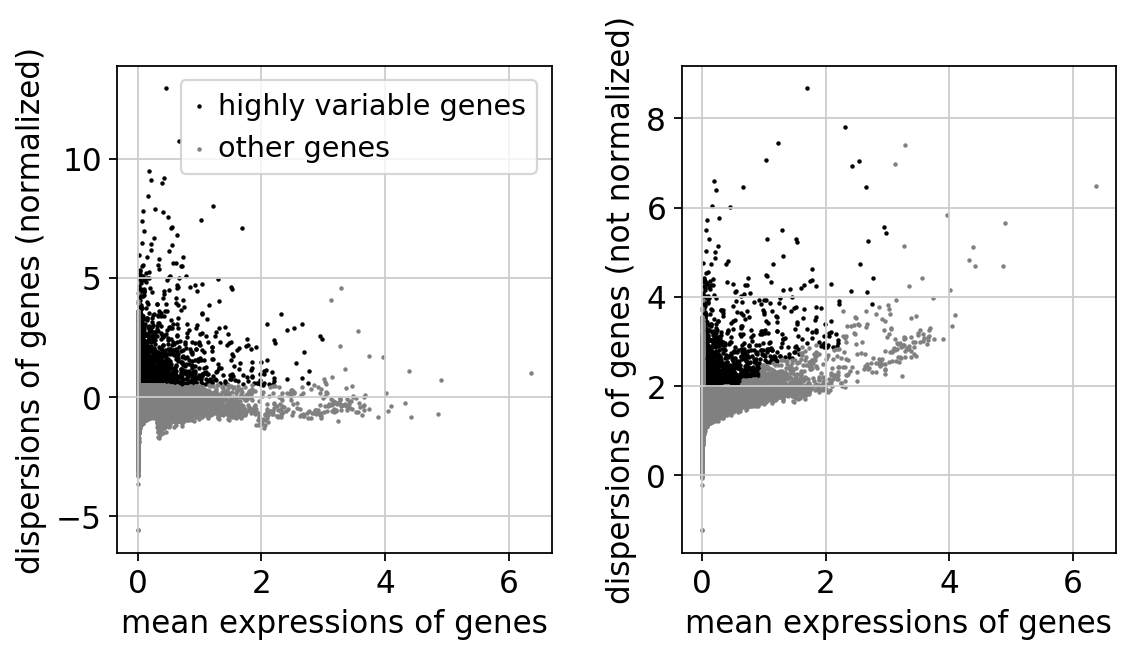

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
adata = adata[:, adata.var.highly_variable]

In [25]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:29.35)


In [26]:
adata

AnnData object with n_obs × n_vars = 5500 × 2852 
    obs: 'batch', 'CellID', 'cell_ontology_class', 'channel', 'tissue', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids-Lung-10X_P7_8', 'gene_ids-Lung-10X_P7_9', 'gene_ids-Lung-10X_P8_12', 'gene_ids-Lung-10X_P8_13', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [27]:
adata_base = adata.copy()

In [28]:
sc.pp.scale(adata_base, max_value=10)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


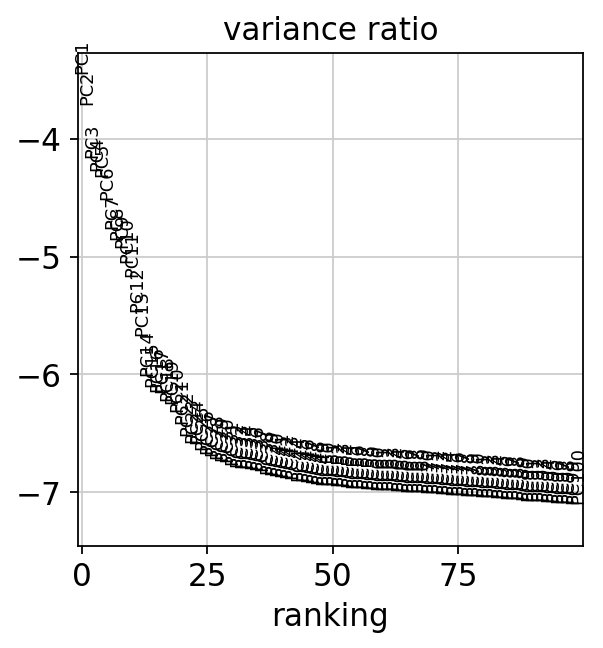

In [29]:
## PCA
sc.tl.pca(adata_base, n_comps=100, svd_solver='arpack')
# Pick nPC
sc.pl.pca_variance_ratio(adata_base, log=True, show=100, n_pcs=100)

In [30]:
#nPC=45
sc.pp.neighbors(adata_base, n_pcs=45, n_neighbors=15)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:05.65) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [31]:
#run tSNE
sc.tl.tsne(adata_base, n_pcs=45, use_fast_tsne=True, n_jobs=20, perplexity=30)

computing tSNE
    using 'X_pca' with n_pcs = 45
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:32.91) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


saving figure to file ./figures/tsne_Batch_Baseline.pdf


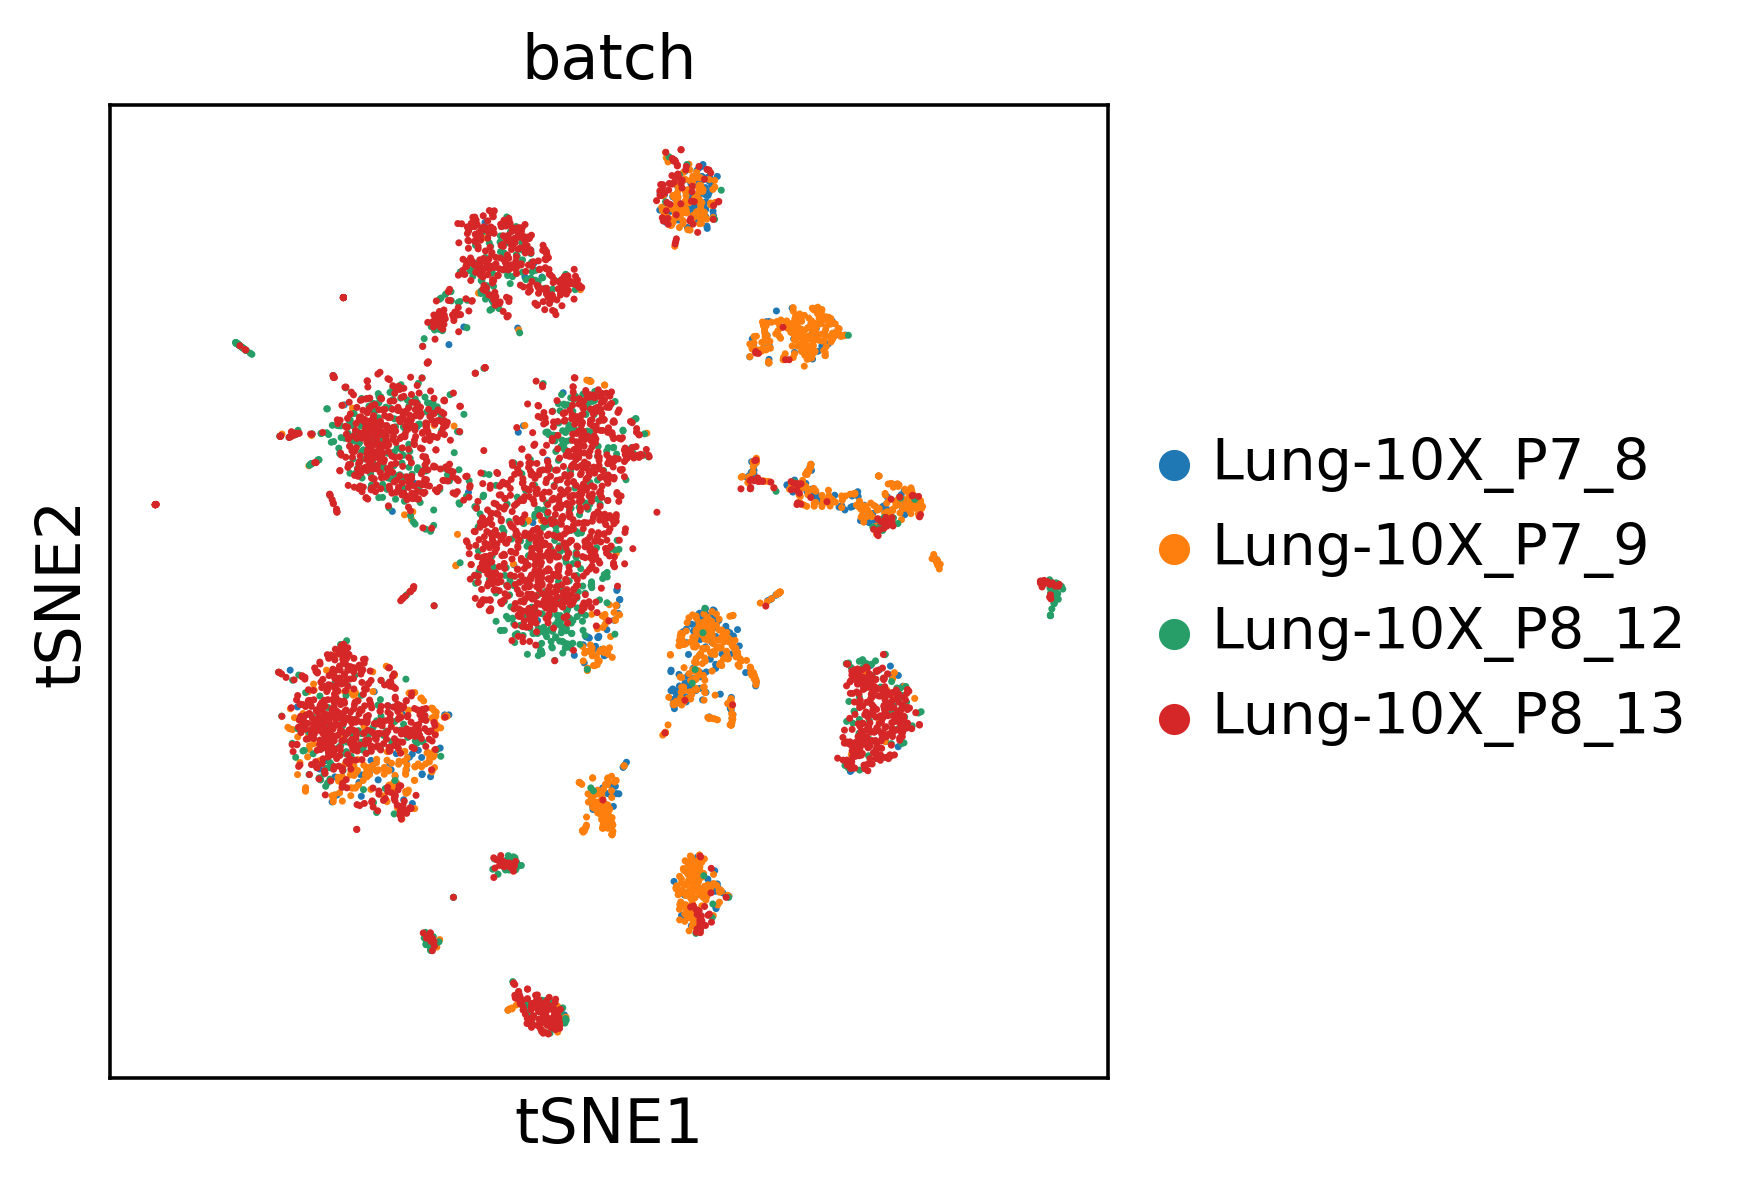

In [18]:
sc.pl.tsne(adata_base, color=['batch'], size=10, save="_Batch_Baseline.pdf")

saving figure to file ./figures/tsne_CellType_Baseline.pdf


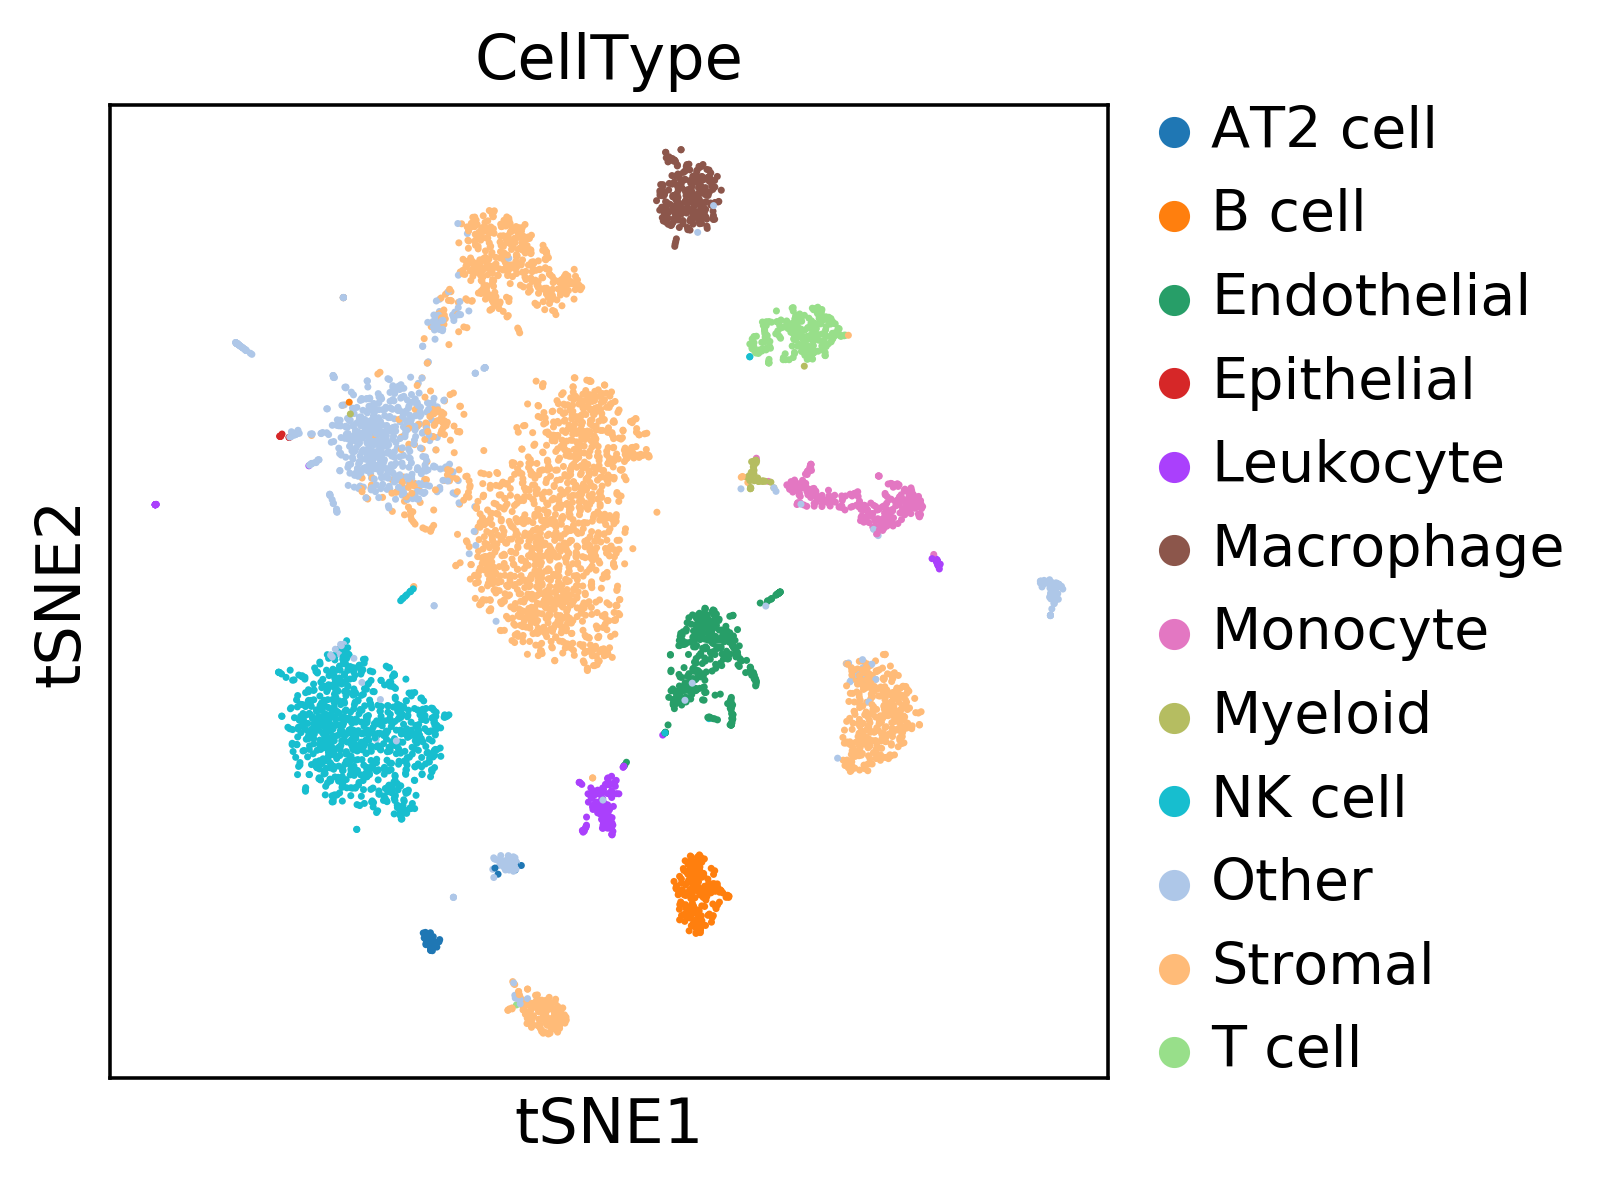

In [19]:
sc.pl.tsne(adata_base, color=['CellType'], size=10, save="_CellType_Baseline.pdf")

saving figure to file ./figures/tsne_CellType_Baseline_ondata.pdf


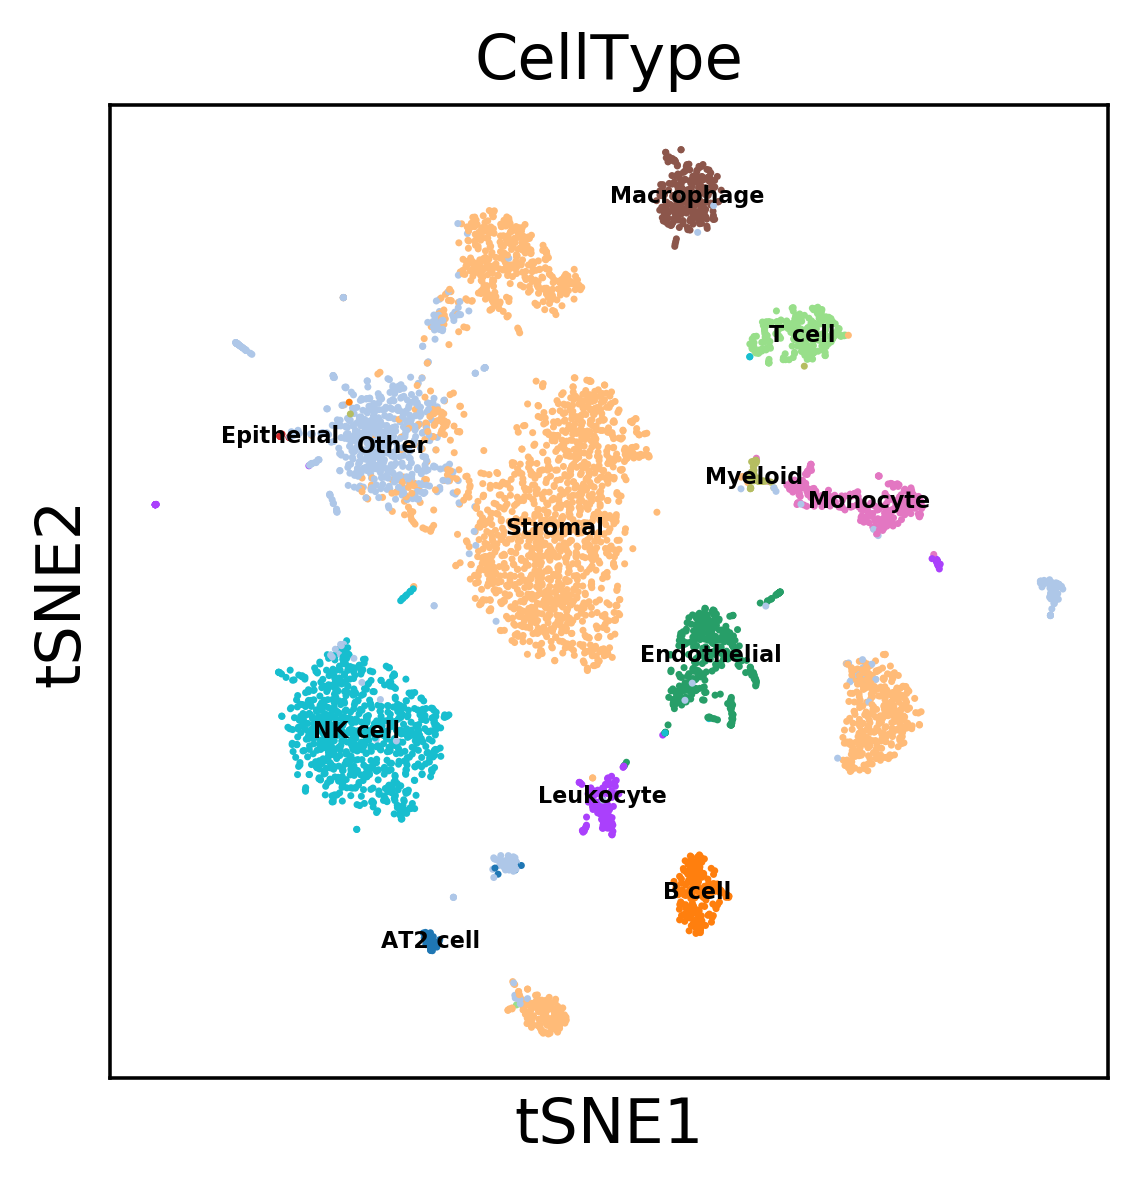

In [20]:
sc.pl.tsne(adata_base, color=['CellType'], size=10, legend_loc='on data', legend_fontsize=5, save="_CellType_Baseline_ondata.pdf")

saving figure to file ./figures/tsne_Cluster_baseline.pdf


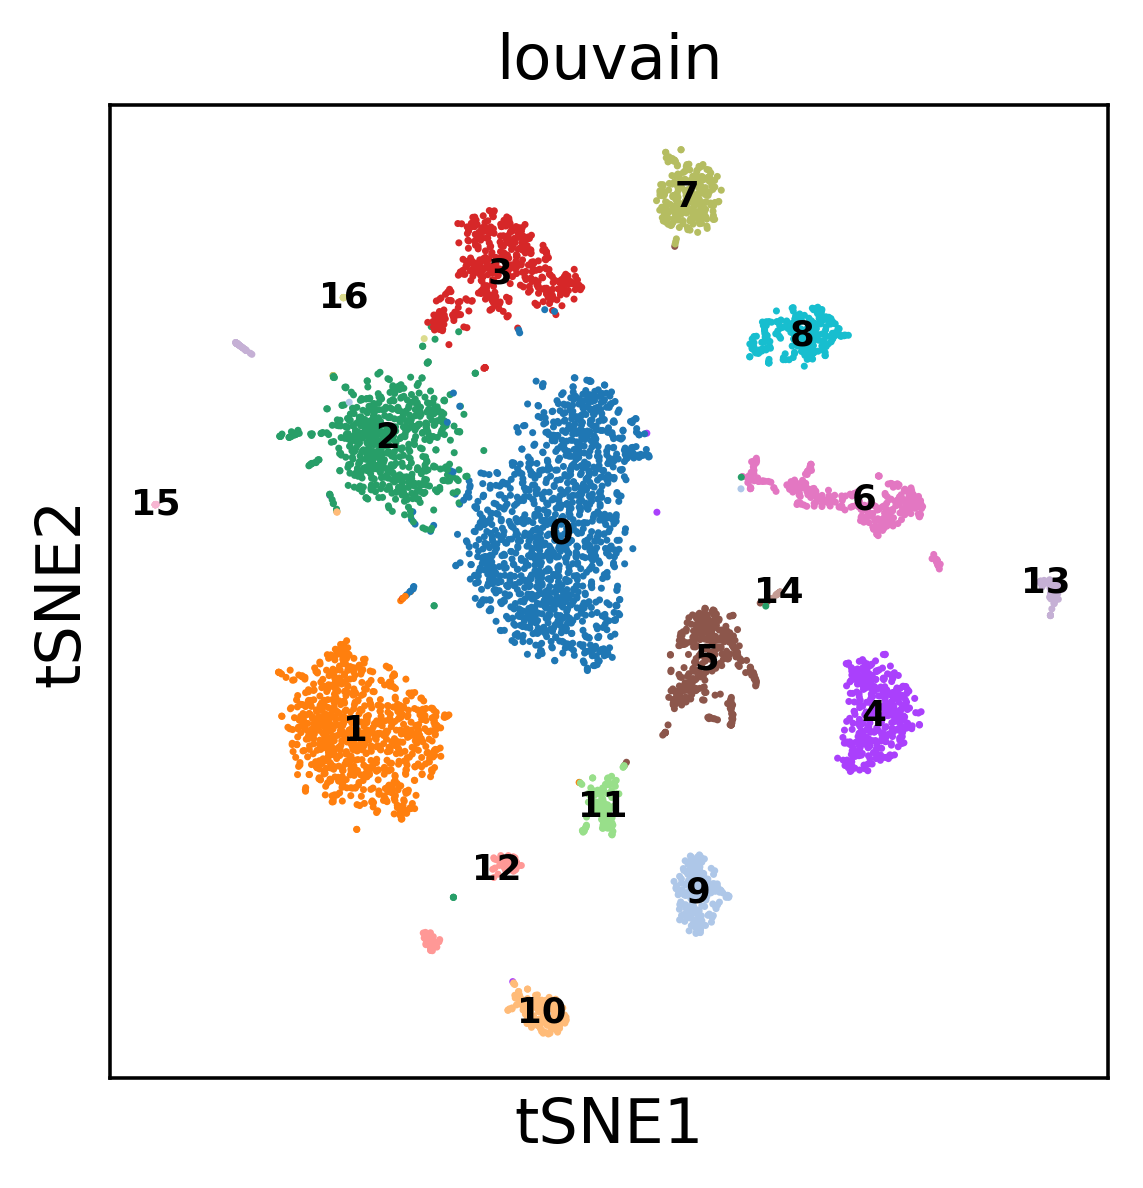

In [21]:
#res=0.6
sc.tl.louvain(adata_base, resolution=0.6)
sc.pl.tsne(adata_base, color='louvain', size=10, legend_loc='on data', legend_fontsize=8,save='_Cluster_baseline.pdf')

In [11]:
adata_base.obs.to_csv("./cluster_Baseline.txt", index=False)

In [38]:
adata_reg = adata.copy()

In [39]:
%%time
sc.pp.regress_out(adata_reg, ['batch'])

regressing out ['batch']
    finished (0:00:31.14)
CPU times: user 7min 44s, sys: 8min 13s, total: 15min 57s
Wall time: 31.2 s


In [40]:
## scale the data
sc.pp.scale(adata_reg, max_value=10)

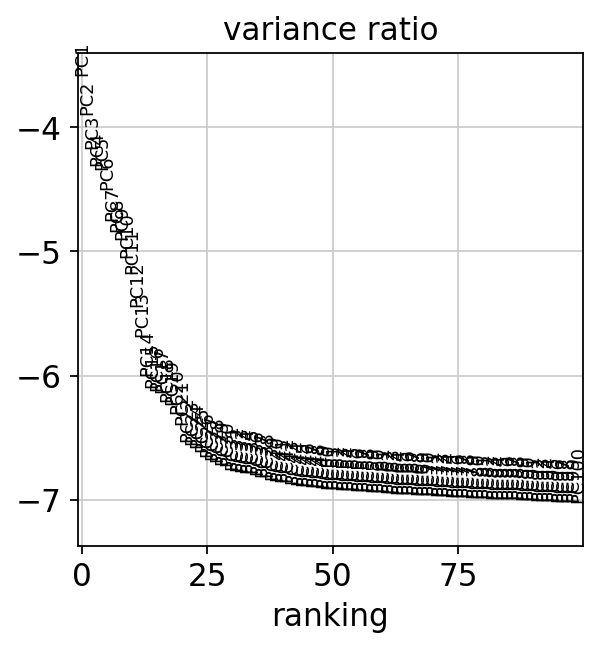

In [43]:
## PCA
sc.tl.pca(adata_reg,  n_comps=100, svd_solver='arpack')
# Pick nPC
sc.pl.pca_variance_ratio(adata_reg, log=True, show=100, n_pcs=100)

In [44]:
#nPC=45
sc.pp.neighbors(adata_reg, n_pcs=45, n_neighbors=15)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:01.87) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [45]:
#run tSNE
sc.tl.tsne(adata_reg, n_pcs=45, use_fast_tsne=True, n_jobs=20, perplexity=30)

computing tSNE
    using 'X_pca' with n_pcs = 45
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:26.37) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


saving figure to file ./figures/tsne_Batch_reg.pdf


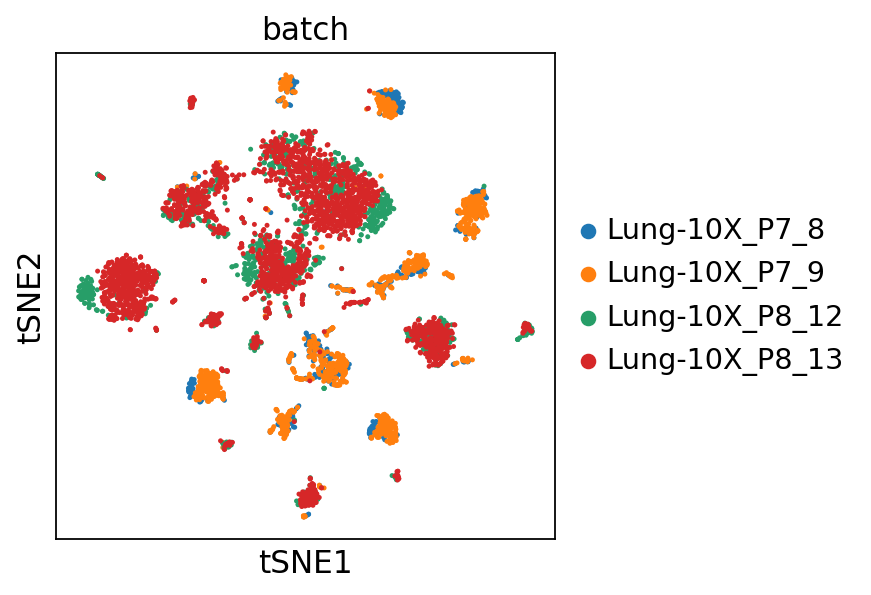

In [46]:
sc.pl.tsne(adata_reg, color=['batch'], size=20, save="_Batch_reg.pdf")

saving figure to file ./figures/tsne_CellType_reg.pdf


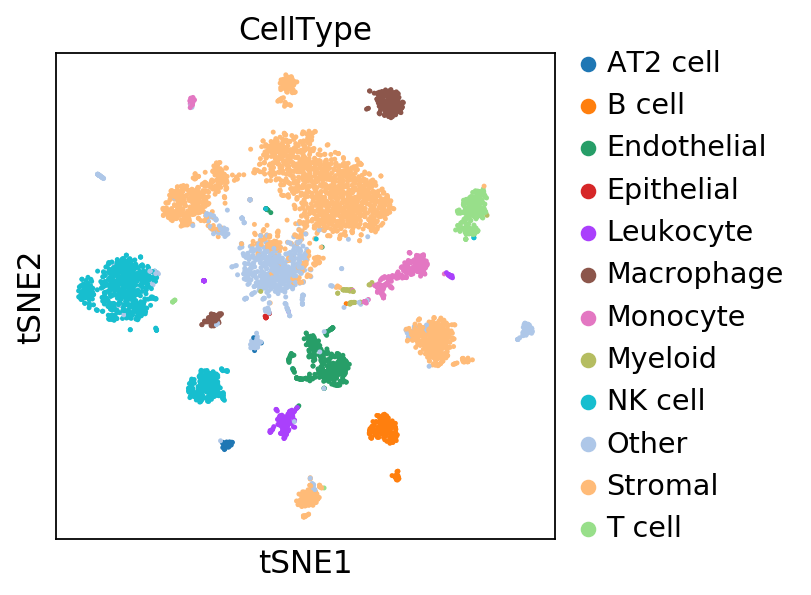

In [47]:
sc.pl.tsne(adata_reg, color=['CellType'], size=20, save="_CellType_reg.pdf")

saving figure to file ./figures/tsne_CellType_reg_ondata.pdf


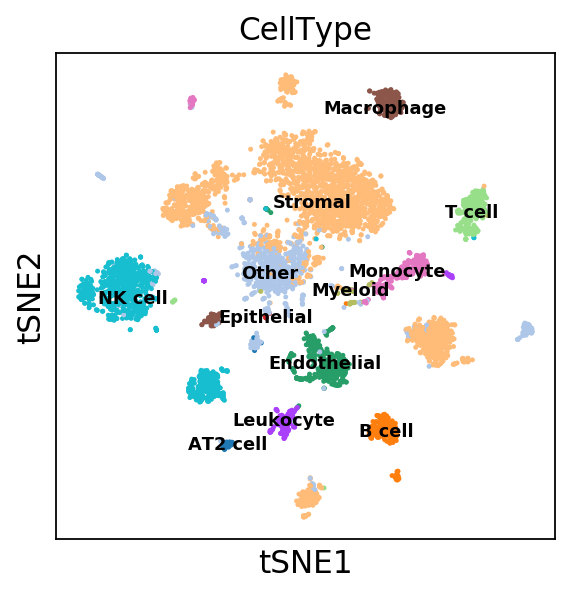

In [48]:
sc.pl.tsne(adata_reg, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_reg_ondata.pdf")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.43) --> found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/tsne_Cluster_reg.pdf


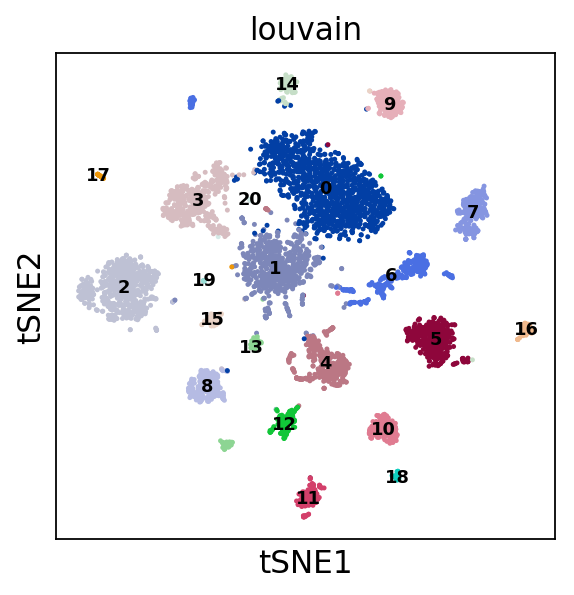

In [49]:
#res=0.6
sc.tl.louvain(adata_reg, resolution=0.6)
sc.pl.tsne(adata_reg, color='louvain',size=20,legend_loc='on data', legend_fontsize=8, save='_Cluster_reg.pdf')

In [12]:
adata_reg.obs.to_csv("./cluster_reg.txt", index=False)

In [51]:
adata_combat = adata.copy()

In [53]:
%%time
sc.pp.combat(adata_combat, key='batch')

Standardizing Data across genes.
found 4 batches
found 0 categorical variables:	
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting data
CPU times: user 36.4 s, sys: 31.3 s, total: 1min 7s
Wall time: 4.69 s


In [54]:
## scale the data
sc.pp.scale(adata_combat, max_value=10)

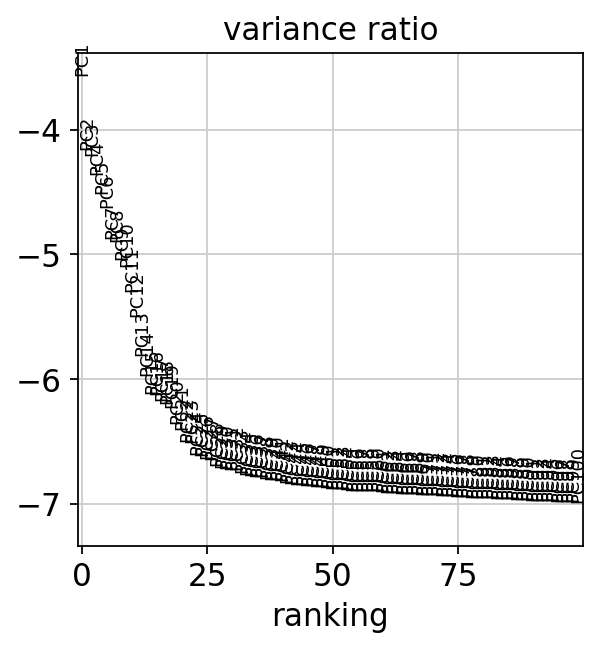

In [55]:
## PCA
sc.tl.pca(adata_combat,  n_comps=100, svd_solver='arpack')
# Pick nPC
sc.pl.pca_variance_ratio(adata_combat, log=True, show=100, n_pcs=100)

In [56]:
#nPC=45
sc.pp.neighbors(adata_combat, n_neighbors=15, n_pcs=45)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:02.10) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [59]:
#run tSNE
sc.tl.tsne(adata_combat, n_pcs=45, use_fast_tsne=True, n_jobs=20, perplexity=30)

computing tSNE
    using 'X_pca' with n_pcs = 45
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:20.28) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


saving figure to file ./figures/tsne_Batch_Combat.pdf


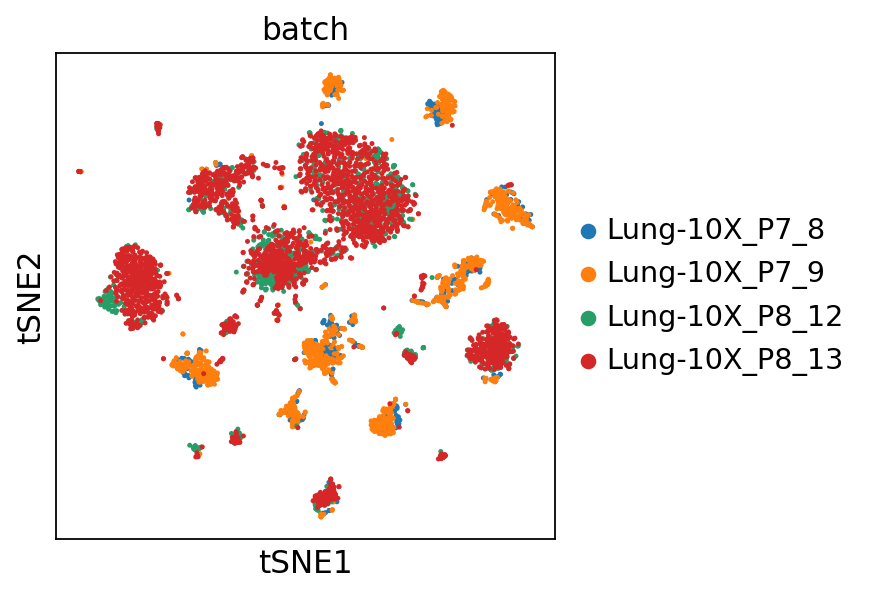

In [60]:
sc.pl.tsne(adata_combat, color=['batch'], size=20, save="_Batch_Combat.pdf")

saving figure to file ./figures/tsne_CellType_Combat.pdf


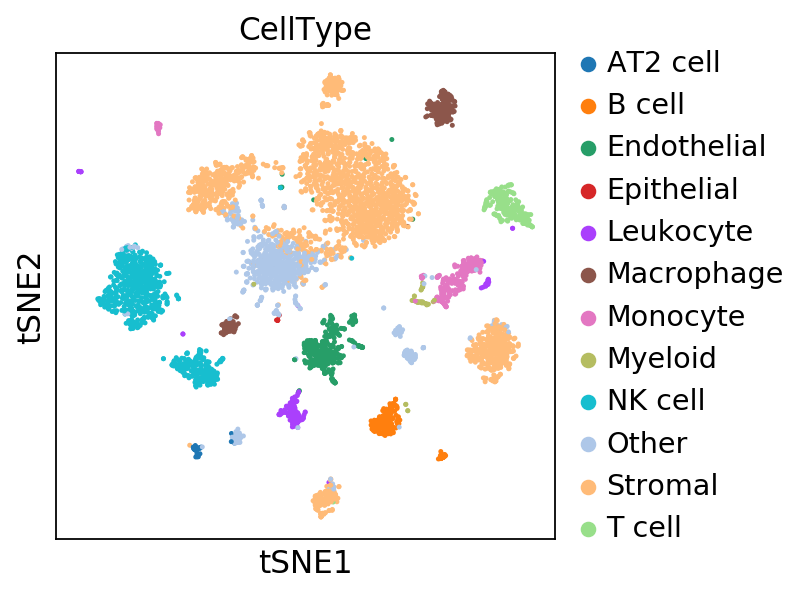

In [61]:
sc.pl.tsne(adata_combat, color=['CellType'], size=20, save="_CellType_Combat.pdf")

saving figure to file ./figures/tsne_CellType_Combat_ondata.pdf


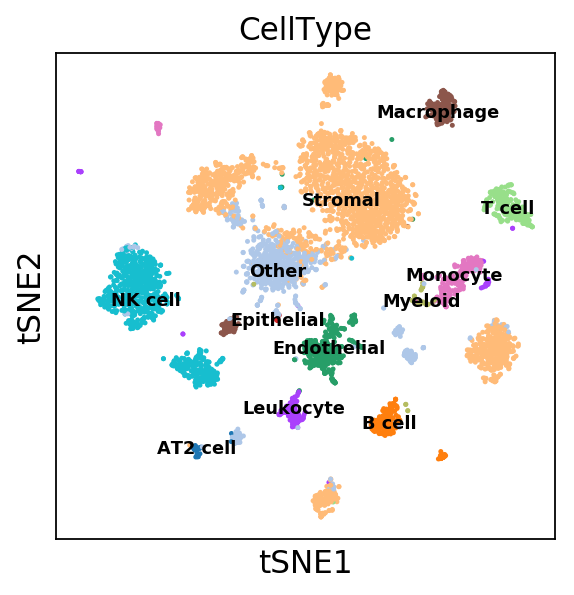

In [62]:
sc.pl.tsne(adata_combat, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_Combat_ondata.pdf")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.41) --> found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/tsne_Cluster_Combat.pdf


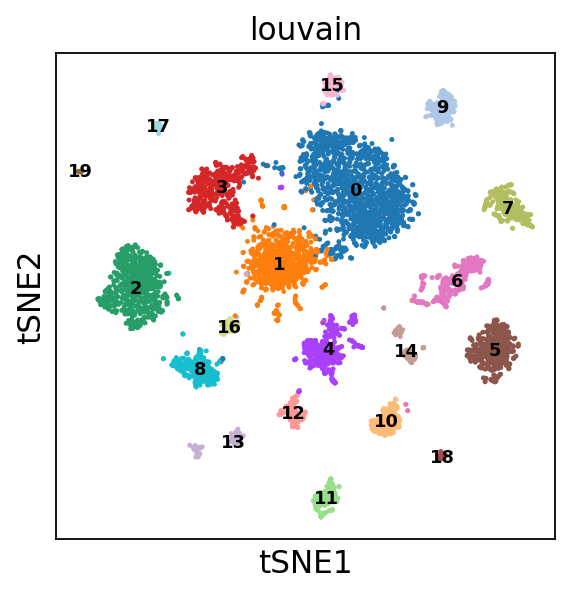

In [63]:
#res=0.6
sc.tl.louvain(adata_combat, resolution=0.6)
sc.pl.tsne(adata_combat, color='louvain', size=20, legend_loc='on data', legend_fontsize=8,save='_Cluster_Combat.pdf')

In [13]:
adata_combat.obs.to_csv("./cluster_Combat.txt", index=False)

In [69]:
import scanorama

In [65]:
adata_scanorama = adata.copy()

In [67]:
adata_list = [adata_scanorama[adata_scanorama.obs['batch'] == i] for i in adata_scanorama.obs['batch'].unique()]

In [68]:
#check
print(adata_list[0].shape)
print(adata_list[0])

(462, 2852)
View of AnnData object with n_obs × n_vars = 462 × 2852 
    obs: 'batch', 'CellID', 'cell_ontology_class', 'channel', 'tissue', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids-Lung-10X_P7_8', 'gene_ids-Lung-10X_P7_9', 'gene_ids-Lung-10X_P8_12', 'gene_ids-Lung-10X_P8_13', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [70]:
%%time
intergrated, corrected = scanorama.correct_scanpy(adata_list, return_dimred=True)

Found 2852 genes among all datasets
[[0.         0.91774892 0.23809524 0.38744589]
 [0.         0.         0.39269051 0.53499222]
 [0.         0.         0.         0.92731049]
 [0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (0, 1)
Processing datasets (1, 3)
Processing datasets (1, 2)
Processing datasets (0, 3)
Processing datasets (0, 2)
CPU times: user 2min 42s, sys: 1min 38s, total: 4min 21s
Wall time: 31.6 s


In [73]:
corrected_merged_dge = corrected[0].concatenate(*corrected[1:])
corrected_merged_dge.obs = adata_scanorama.obs

In [74]:
## scale the data
sc.pp.scale(corrected_merged_dge, max_value=10)

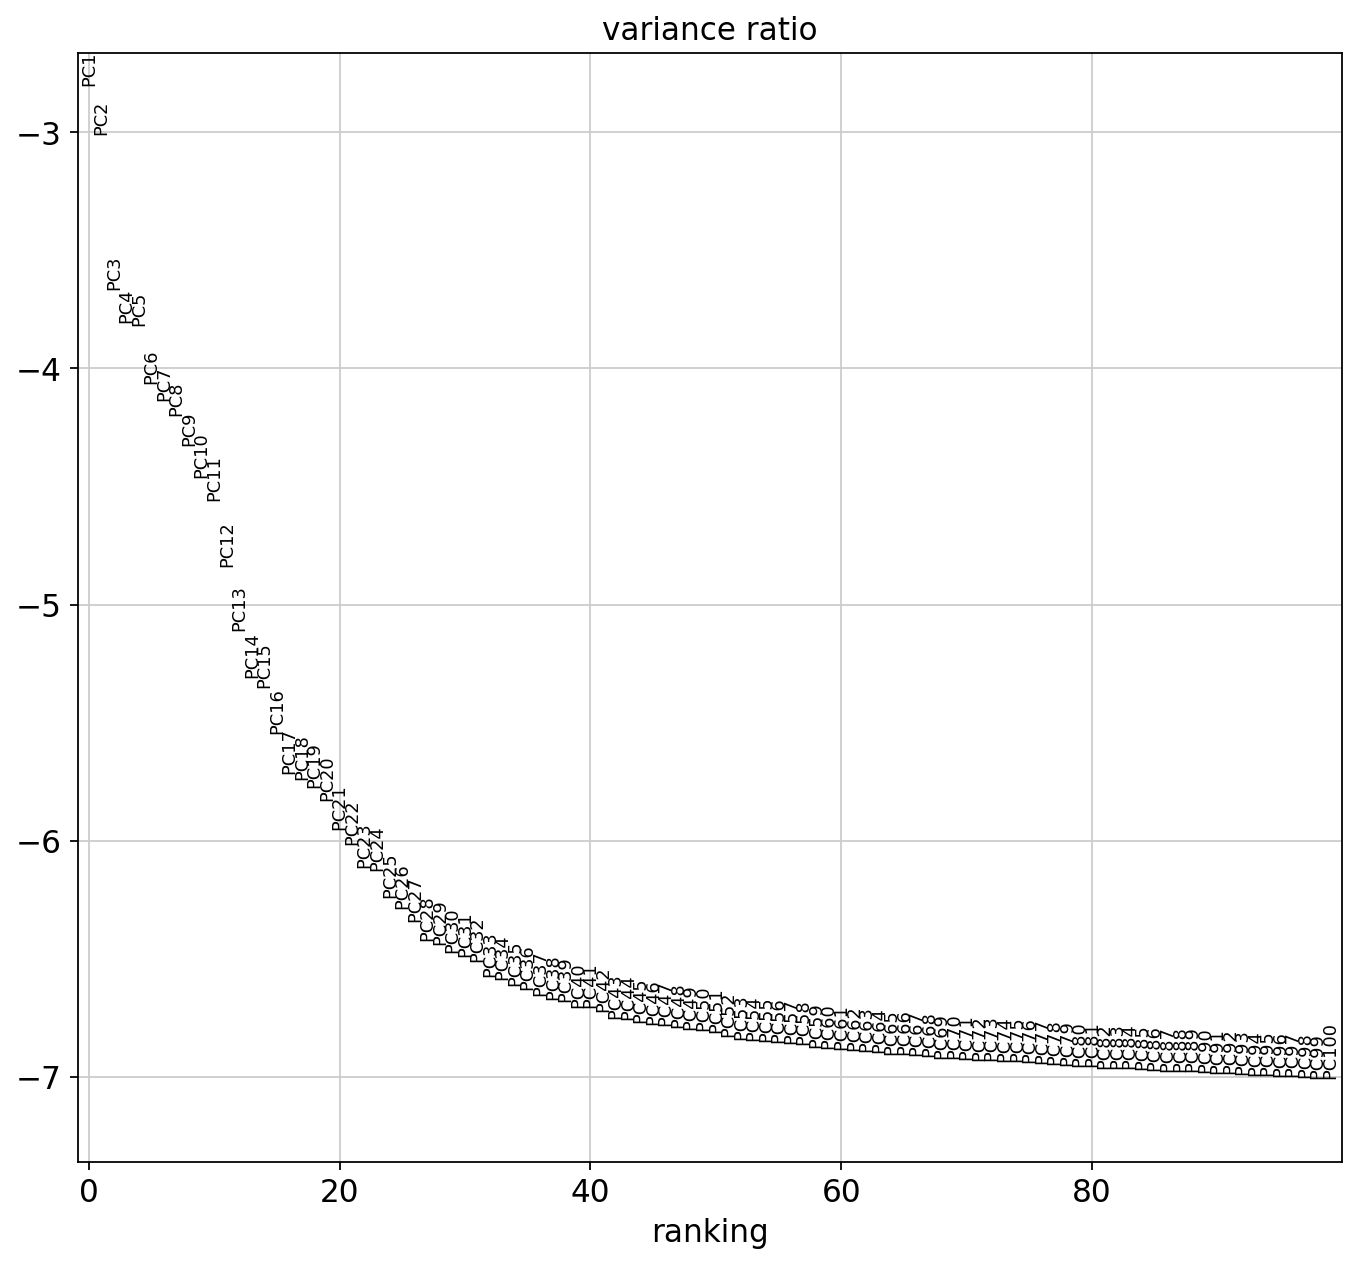

In [76]:
## PCA
sc.tl.pca(corrected_merged_dge, n_comps=100, svd_solver='arpack')
# Pick nPC
sc.pl.pca_variance_ratio(corrected_merged_dge, log=True, show=100, n_pcs=100)

In [77]:
#nPC=45
sc.pp.neighbors(corrected_merged_dge, n_neighbors=15, n_pcs=45)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:02.02) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [78]:
#run tSNE
sc.tl.tsne(corrected_merged_dge, n_pcs=45, use_fast_tsne=True, n_jobs=20, perplexity=30)

computing tSNE
    using 'X_pca' with n_pcs = 45
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:35.35) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


saving figure to file ./figures/tsne_Batch_Scanorama_1.pdf


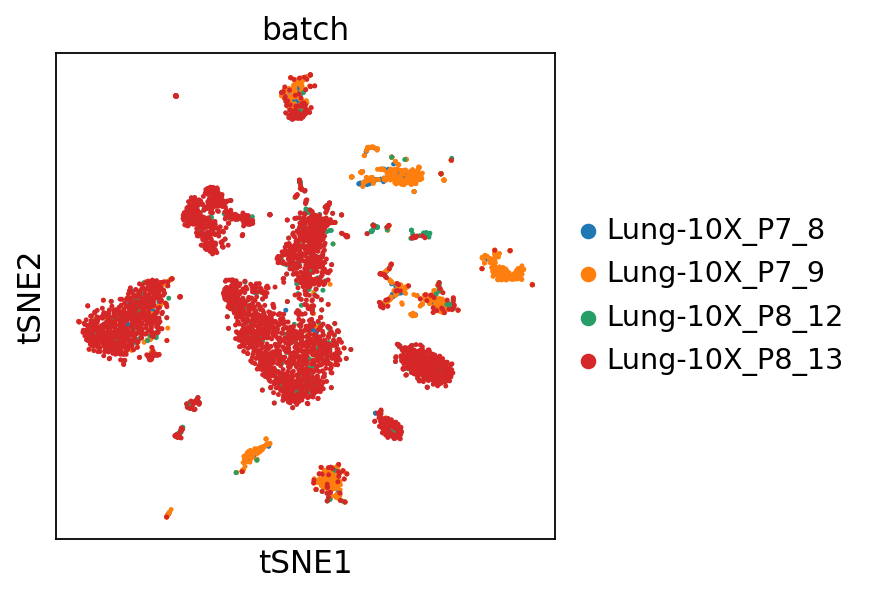

saving figure to file ./figures/tsne_CellType_Scanorama_1.pdf


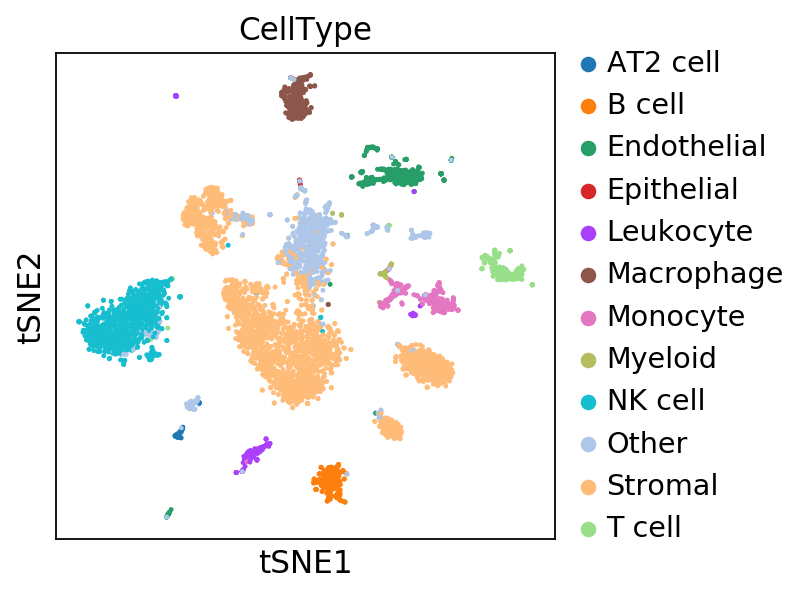

saving figure to file ./figures/tsne_CellType_Scanoram_1_ondata.pdf


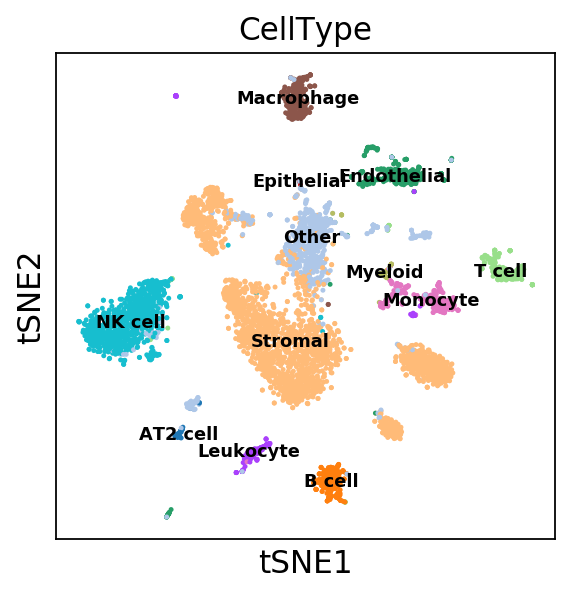

In [4]:
sc.pl.tsne(corrected_merged_dge, color=['batch'], size=20, save="_Batch_Scanorama.pdf")
sc.pl.tsne(corrected_merged_dge, color=['CellType'], size=20, save="_CellType_Scanorama.pdf")
sc.pl.tsne(corrected_merged_dge, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_Scanoram_ondata.pdf")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.44) --> found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/tsne_Cluster_Scanorama_1.pdf


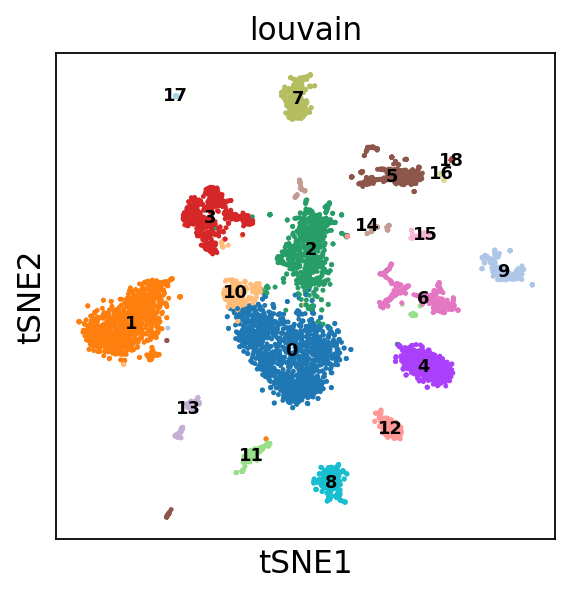

In [5]:
#res=0.6
sc.tl.louvain(corrected_merged_dge, resolution=0.6)
sc.pl.tsne(corrected_merged_dge, color='louvain', size=20, legend_loc='on data', legend_fontsize=8,save='_Cluster_Scanorama.pdf')

In [14]:
corrected_merged_dge.obs.to_csv("./cluster_Scanorama.txt", index=False)

In [3]:
#corrected_merged_dge=sc.read("adata_scanorama.h5ad")
#corrected_merged_dge

AnnData object with n_obs × n_vars = 5500 × 2852 
    obs: 'batch', 'CellID', 'cell_ontology_class', 'channel', 'tissue', 'CellType', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'CellType_colors', 'batch_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

In [87]:
adata_mnn = adata.copy()

In [89]:
%%time
adata_mnn, _, _ = sc.external.pp.mnn_correct(*adata_list)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 3: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 3: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 3 of 3: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.
CPU times: user 11min 53s, sys: 28.1 s, total: 12min 21s
Wall time: 58.1 s


In [92]:
## scale the data
sc.pp.scale(adata_mnn, max_value=10)

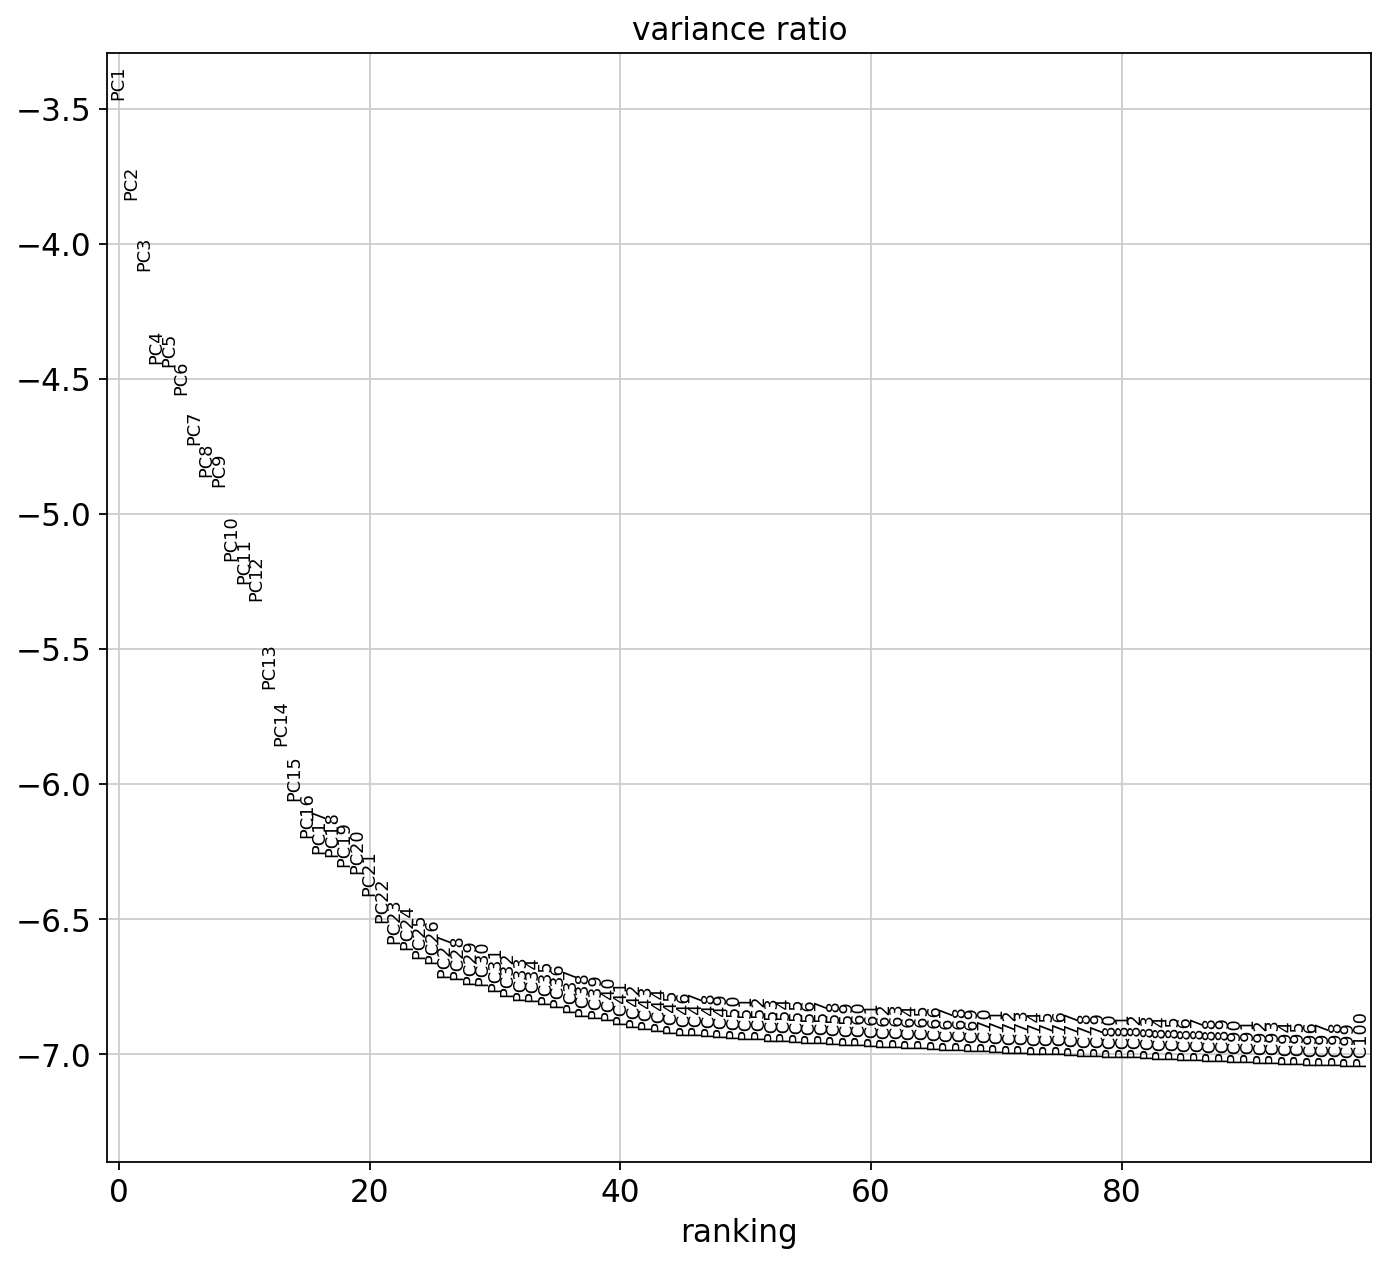

In [93]:
## PCA
sc.tl.pca(adata_mnn, n_comps=100, svd_solver='arpack')
# Pick nPC
sc.pl.pca_variance_ratio(adata_mnn, log=True, show=100, n_pcs=100)

In [94]:
#nPC=45
sc.pp.neighbors(adata_mnn, n_pcs=45, n_neighbors=15)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:01.94) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [95]:
sc.tl.tsne(adata_mnn, n_pcs=45, use_fast_tsne=True, n_jobs=20, perplexity=30)

computing tSNE
    using 'X_pca' with n_pcs = 45
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:19.59) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


saving figure to file ./figures/tsne_Batch_mnn.pdf


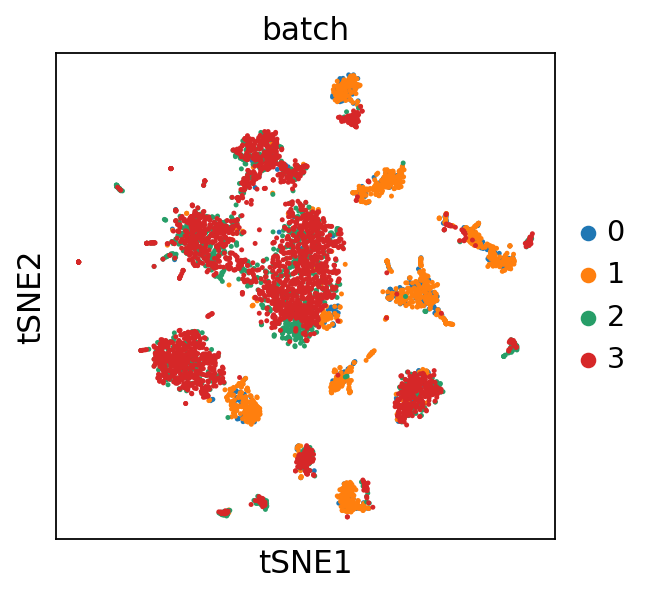

saving figure to file ./figures/tsne_CellType_mnn.pdf


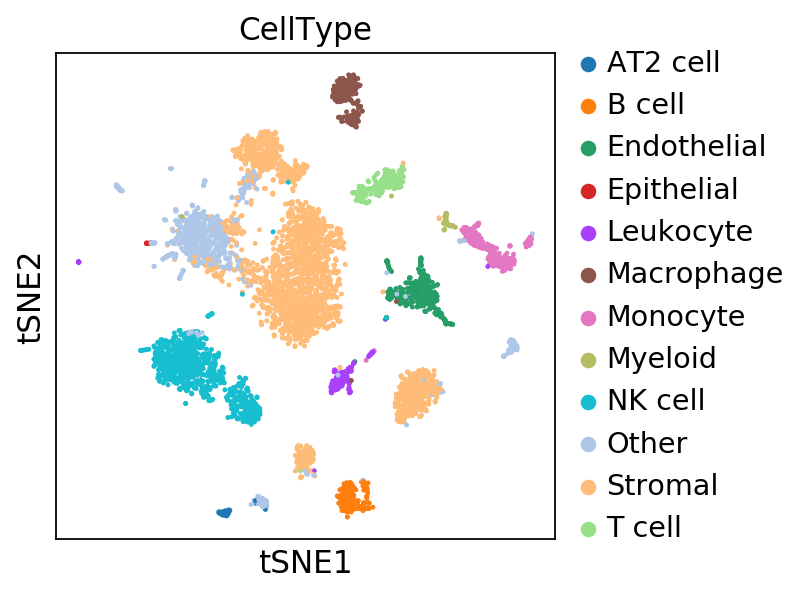

saving figure to file ./figures/tsne_CellType_mnn_ondata.pdf


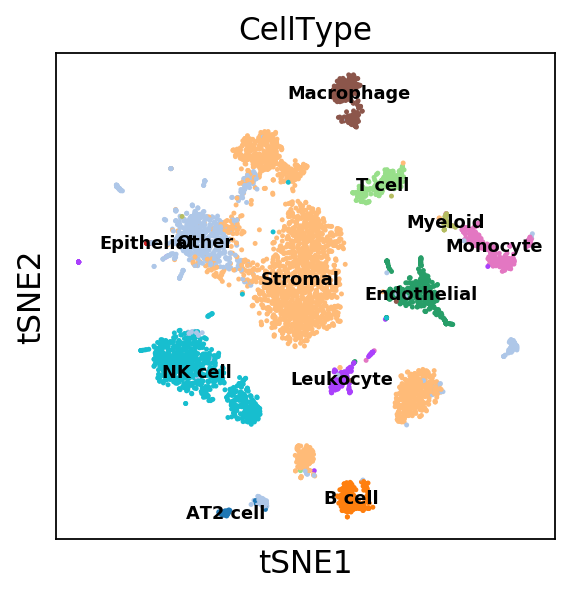

In [7]:
sc.pl.tsne(adata_mnn, color=['batch'], size=20, save="_Batch_mnn.pdf")
sc.pl.tsne(adata_mnn, color=['CellType'], size=20, save="_CellType_mnn.pdf")
sc.pl.tsne(adata_mnn, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_mnn_ondata.pdf")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.70) --> found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/tsne_Cluster_mnn.pdf


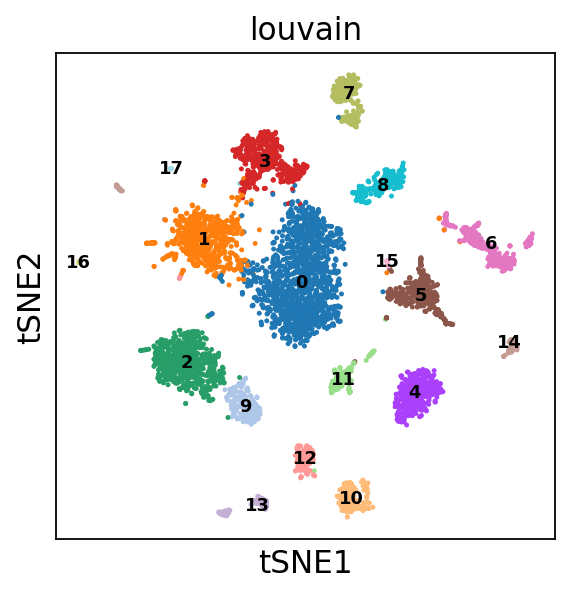

In [8]:
#res=0.6
sc.tl.louvain(adata_mnn, resolution=0.6)
sc.pl.tsne(adata_mnn, color='louvain', size=20, legend_loc='on data', legend_fontsize=8,save='_Cluster_mnn.pdf')

In [15]:
adata_mnn.obs.to_csv("./cluster_mnn.txt", index=False)

In [6]:
#adata_mnn=sc.read("adata_mnns.h5ad")
#adata_mnn

AnnData object with n_obs × n_vars = 5500 × 2852 
    obs: 'CellID', 'CellType', 'batch', 'cell_ontology_class', 'channel', 'n_counts', 'n_genes', 'percent_mito', 'tissue', 'louvain'
    var: 'gene_ids-Lung-10X_P7_8-0', 'gene_ids-Lung-10X_P7_9-0', 'gene_ids-Lung-10X_P8_12-0', 'gene_ids-Lung-10X_P8_13-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-Lung-10X_P7_8-1', 'gene_ids-Lung-10X_P7_9-1', 'gene_ids-Lung-10X_P8_12-1', 'gene_ids-Lung-10X_P8_13-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-Lung-10X_P7_8-2', 'gene_ids-Lung-10X_P7_9-2', 'gene_ids-Lung-10X_P8_12-2', 'gene_ids-Lung-10X_P8_13-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'gene_ids-Lung-10X_P7_8-3', 'gene_ids-Lung-10X_P7_9-3', 'gene_ids-Lung-10X_P8_12-3', 'gene_ids-Lung-10X_P8_13-3', 'n_cells-3', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3'
    uns: 'CellTyp

In [107]:
adata.write("./adata.h5ad")
adata_base.write("./adata_base.h5ad")
adata_combat.write("./adata_combat.h5ad")
adata_reg.write("./adata_reg.h5ad")
corrected_merged_dge.write("./adata_scanorama.h5ad")
adata_mnn.write("./adata_mnns.h5ad")

In [3]:
adata_base = sc.read_h5ad("./adata_base.h5ad")
adata_combat = sc.read_h5ad("./adata_combat.h5ad")
adata_reg = sc.read_h5ad("./adata_reg.h5ad")
corrected_merged_dge = sc.read_h5ad("./adata_scanorama.h5ad")
adata_mnn = sc.read_h5ad("./adata_mnns.h5ad")

In [ ]:
sc.pl.tsne(adata_base, color=['batch'], size=10, save="_Batch_Baseline.pdf")
sc.pl.tsne(adata_base, color=['CellType'], size=10, save="_CellType_Baseline.pdf")

In [21]:
import glob
fnames = glob.glob("adata_*.h5ad")
fnames

['adata_base.h5ad',
 'adata_combat.h5ad',
 'adata_reg.h5ad',
 'adata_mnns.h5ad',
 'adata_scanorama.h5ad',
 'adata_bbknn.h5ad']

In [22]:
for fname in fnames:
    adata = sc.read_h5ad(fname)
    df = pd.DataFrame(adata.X)
    df.index = adata.obs
    df.columns = adata.var
    df.to_csv(fname.split('.')[0]+'.dge.csv')